In [1]:
import pyet
import pandas as pd
import altair as alt
import xarray as xr
from metpy.units import units
import pint_pandas

In [2]:
# Inputs
start_date = '20221130'
end_date = '20230517'
met_gothic = 'gucmetM1.b1'
tsi_sail_code = 'guctsiskycoverM1.b1'
data_dir = '/data2/elilouis/sublimationofsnow'
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

In [3]:
elev = 2863# from google earth


# Gather all variables we need
src = tidy_df_5Min[tidy_df_5Min.variable.isin([
    'T_3m_c',
    'spd_3m_c',
    'RH_3m_c',
    'Rnet_9m_d',
    'Rsw_in_9m_d',
    'T_3m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index().set_index('time').groupby(pd.Grouper(freq='30Min')).agg({
    'T_3m_c': ['mean', 'min', 'max'],
    'spd_3m_c': 'mean',
    'RH_3m_c': ['mean', 'min', 'max'],
    'Rnet_9m_d': 'mean',
    'Rsw_in_9m_d': 'mean',
})
# Remove the resulting hierarchical index
src.columns = ['_'.join(col).strip() for col in src.columns.values]
# Drop nans
# src = src.dropna()

# # # Convert W/m^2 to MJ/m^2/d
src['Rnet_9m_d_mean'] = pd.Series(src['Rnet_9m_d_mean'].values, dtype="pint[W/m^2]").pint.to('MJ/m^2/d').pint.magnitude.values
src['Rsw_in_9m_d_mean'] = pd.Series(src['Rsw_in_9m_d_mean'].values, dtype="pint[W/m^2]").pint.to('MJ/m^2/d').pint.magnitude.values
src['elevation'] = elev
src

,T_3m_c_mean,T_3m_c_min,T_3m_c_max,spd_3m_c_mean,RH_3m_c_mean,RH_3m_c_min,RH_3m_c_max,Rnet_9m_d_mean,Rsw_in_9m_d_mean,elevation
time,,,,,,,,,,
2022-11-29 17:00:00,-12.797492,-13.113847,-12.469777,3.323426,65.300786,58.585175,70.529083,-4.965172,-0.352467,2863
2022-11-29 17:30:00,-13.050861,-13.396750,-12.794490,4.556745,50.735089,47.638996,57.609478,-6.844837,-0.382727,2863
2022-11-29 18:00:00,-13.382802,-13.790894,-12.837063,3.731591,50.324087,46.751404,53.483006,-6.385244,-0.371056,2863
2022-11-29 18:30:00,-14.988197,-16.231266,-13.597954,1.838974,61.213638,53.338619,71.663116,-5.593020,-0.589699,2863
2022-11-29 19:00:00,-16.329076,-16.716507,-15.913083,1.354227,70.831669,68.301453,72.228645,-4.858094,-0.615169,2863
...,...,...,...,...,...,...,...,...,...,...
2023-05-17 15:30:00,13.910910,13.751372,14.084917,4.693956,30.443745,29.549730,31.339897,NaN,NaN,2863
2023-05-17 16:00:00,13.517461,13.063477,13.964637,4.374811,33.170502,31.718903,34.130718,NaN,NaN,2863
2023-05-17 16:30:00,13.357073,13.186260,13.732280,4.092707,32.588952,30.634781,33.968578,NaN,NaN,2863


In [4]:
sublimation_pm = pyet.pm(
        tmean = src['T_3m_c_mean'],
        wind = src['spd_3m_c_mean'],
        rh = src['RH_3m_c_mean'],
        rhmin = src['RH_3m_c_min'],
        rhmax = src['RH_3m_c_max'],
        tmin = src['T_3m_c_min'],
        tmax = src['T_3m_c_max'],
        rn = src['Rnet_9m_d_mean'],
        elevation = src['elevation'],
        clip_zero=False
    )
sublimation_pm

time
2022-11-29 17:00:00    0.056296
2022-11-29 17:30:00    0.200361
2022-11-29 18:00:00    0.163953
2022-11-29 18:30:00   -0.139421
2022-11-29 19:00:00   -0.194540
                         ...   
2023-05-17 15:30:00         NaN
2023-05-17 16:00:00         NaN
2023-05-17 16:30:00         NaN
2023-05-17 17:00:00         NaN
2023-05-17 17:30:00         NaN
Freq: 30T, Name: Penman_Monteith, Length: 8114, dtype: float64

In [5]:
priestley_taylor = pyet.priestley_taylor(
        tmean = src['T_3m_c_mean'],
        rh = src['RH_3m_c_mean'],
        rhmin = src['RH_3m_c_min'],
        rhmax = src['RH_3m_c_max'],
        tmin = src['T_3m_c_min'],
        tmax = src['T_3m_c_max'],
        rn = src['Rnet_9m_d_mean'],
        elevation = src['elevation'],
        clip_zero=False
)

<AxesSubplot: xlabel='time'>

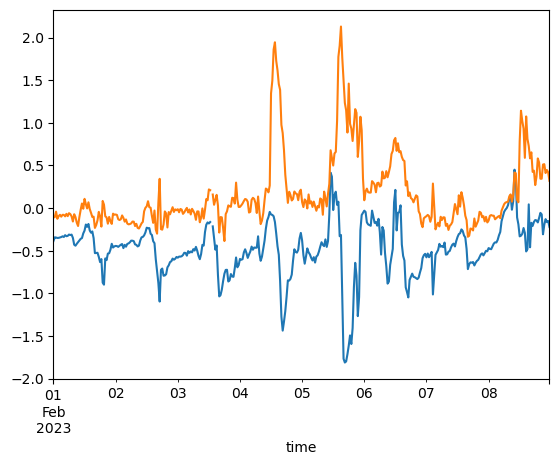

In [6]:
priestley_taylor.loc["2023-02-01":"2023-02-08"].plot(label = 'Priestley Taylor')
sublimation_pm.loc["2023-02-01":"2023-02-08"].plot(label = 'Penman-Monteith')

In [9]:
import metpy.constants
metpy.constants.density_water

999.97495 <Unit('kilogram / meter ** 3')>

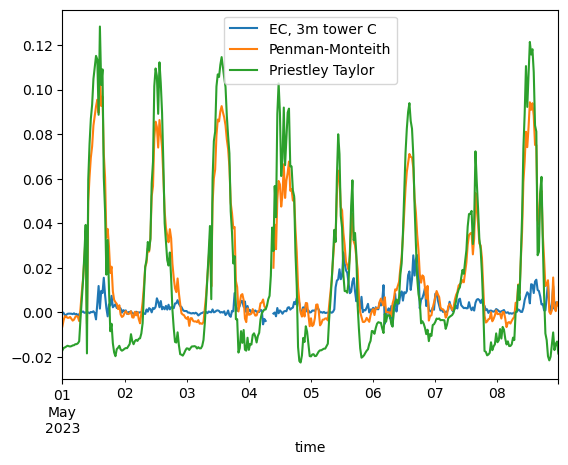

In [28]:
import matplotlib.pyplot as plt
tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index("time")['value'].loc["2023-05-01":"2023-05-08"].plot(label = 'EC, 3m tower C')
(sublimation_pm/(86.4)).loc["2023-05-01":"2023-05-08"].plot(label = 'Penman-Monteith')
(priestley_taylor/(86.4)).loc["2023-05-01":"2023-05-08"].plot(label = 'Priestley Taylor')
plt.legend()